# Data 620 - Project 3
Baron Curtin, Heather Geiger, Mikhail Groysman, Betsy Rosalen 

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python,
and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the devtest set, and the remaining 6900 words for the training set. Then, starting with the example name gender
classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are
satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what
you'd expect? 

In [1]:
# library imports
import random
from collections import Counter
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk import NaiveBayesClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

# jupyter setup
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Data Loading/Preparation
In the following cells, we will be loading the corpus into memory, labelling all of the names, and then randomizing the
list of names for later use. Randomizing the names will ensure that our training/test sets will contain both genders from 
which we should be able to create numerous features from.

In [2]:
# read in names from the files
# label each name with corresponding gender
# names to be lowercase for easy recognition 
males = [(name.lower(), 'male') for name in names.words('male.txt')]
females = [(name.lower(), 'female') for name in names.words('female.txt')]

# combine lists of names
all_names = males + females

# randomize the list
random.shuffle(all_names)

In [20]:
# create each set of data
train = all_names[:500]
dev_test = all_names[500:1000]
test = all_names[-6900:]

6900

## Data Exploration
Lets get a better feel for how our data is composed. Exploration will lead to ways in which we can come up with features.

In [3]:
# create dataframe
data = pd.DataFrame.from_dict(dict(all_names), orient='index', columns=['gender']).reset_index()
data.columns = ['name', 'gender']
data.head()

,name,gender
0,quint,male
1,leonardo,male
2,thelma,female
3,emelita,female
4,cordelia,female


In [4]:
# create various feature columns for exploration
data['length'] = data['name'].str.len()
data['last_letter'] = data['name'].str[-1]
data['first_letter'] = data['name'].str[0]
data['vowel_last_letter'] = data['last_letter'].isin([*'aeiou'])
data['vowel_first_letter'] = data['first_letter'].isin([*'aeiou'])
data['vowels'] = data['name'].str.replace(r'[^aeiou]', '')
data['vowel_count'] = data['vowels'].str.len()

# preview data
data.head()

,name,gender,length,last_letter,first_letter,vowel_last_letter,vowel_first_letter,vowels,vowel_count
0,quint,male,5,t,q,False,False,ui,2
1,leonardo,male,8,o,l,True,False,eoao,4
2,thelma,female,6,a,t,True,False,ea,2
3,emelita,female,7,a,e,True,True,eeia,4
4,cordelia,female,8,a,c,True,False,oeia,4


In [5]:
# use our created variables to generate some summary statistics
data.groupby('gender').mean()

,length,vowel_last_letter,vowel_first_letter,vowel_count
gender,,,,
female,6.147083,0.723417,0.173149,2.673562
male,5.944566,0.234136,0.157185,2.204595


Based on the above chart, we see that females have a higher name length on average, higher vowel counts, and the last letter is 72% of the time a vowel.
These appear to be good predictors. We need to visual confirm what we see numerically

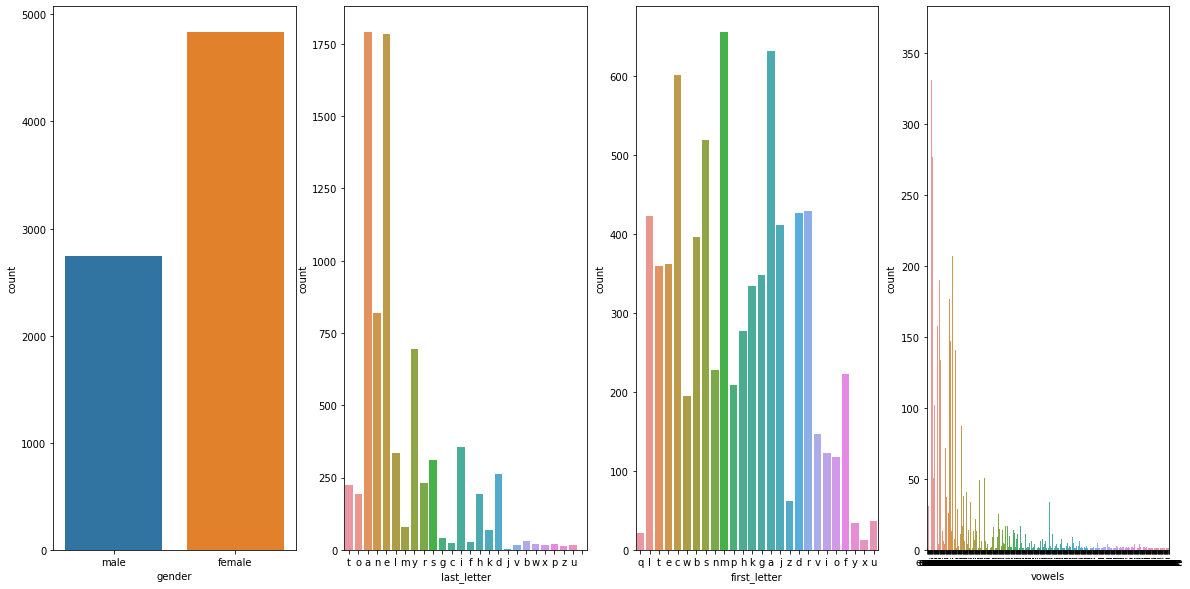

In [11]:
# categorical/numerical columns
categorical_cols = data.loc[:, data.columns != 'name'].select_dtypes(include='object').columns
numerical_cols = data.select_dtypes(include=np.number).columns

fig, ax = plt.subplots(1, 4, figsize=(20, 10))

for var, subplot in zip(categorical_cols, ax.flatten()):
    sns.countplot(x=var, data=data, ax=subplot)


## Feature Creation
Features are the most important part of what goes into a machine learning model. For that reason, it is critically important
to try to come up with features that make the most sense in identifying gender differences in names

In [7]:
# feature generator
def gender_features(name):
    # last letter in name
    last_letter = name[-1]
    
    # vowel last letter
    vowel_last_letter = last_letter in 'aeiou'
    
    # first letter
    first_letter = name[0]
    
    # vowel first letter
    vowel_first_letter = first_letter in 'aeiou'
    
    # tri-grams
    trigrams = ngrams(name, 3)
    
    # vowel count
    vowel_count = len(name.replace(r'[^aeiou]', ''))
    
    # return dictionary
    return {
        'last_letter': last_letter,
        'vowel_last_letter': vowel_last_letter,
        'first_letter': first_letter,
        'vowel_first_letter': vowel_first_letter,
        'trigrams': trigrams,
        'vowel_count': vowel_count
    }